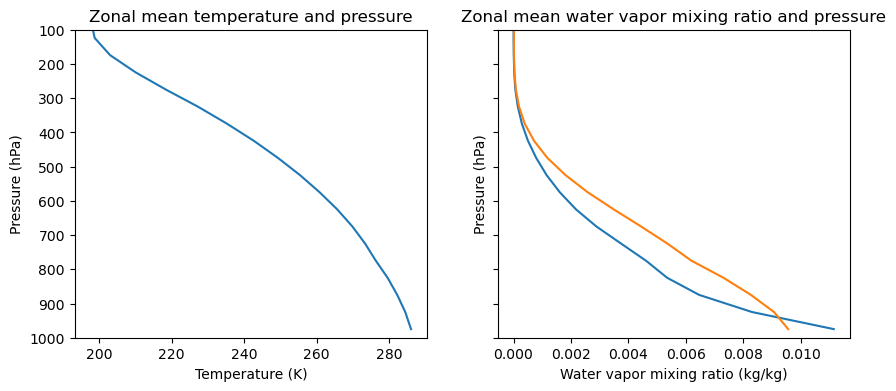

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from metpy.calc import moist_lapse
from metpy.units import units
import climlab

# zonal mean temp., qv, pressure (20, 64)
meanT  = np.load("/home/Quark/2025summer/prec/dycore/meanT.npy")
meanqv = np.load("/home/Quark/2025summer/prec/dycore/meanqv.npy")
meanp  = np.load("/home/Quark/2025summer/prec/dycore/meanp.npy")

nlat = meanT.shape[1]
dlat = 180.0 / nlat
lat_centers = -90 + dlat/2 + np.arange(nlat) * dlat

# weighted avg.
w = np.cos(np.deg2rad(lat_centers))
aaveT = np.average(meanT, axis=1, weights=w)
aaveqv = np.average(meanqv, axis=1, weights=w)
aavep = np.average(meanp, axis=1, weights=w) / 100. # to hPa
qvs_lev = climlab.utils.thermo.qsat(aaveT, aavep)

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

axs[0].plot(aaveT, aavep, label='Temp')
axs[0].set_xlabel('Temperature (K)')
axs[0].set_ylabel('Pressure (hPa)')
axs[0].set_title('Zonal mean temperature and pressure')

axs[1].plot(aaveqv, aavep, label='qv')
axs[1].plot(qvs_lev, aavep, label='qsat')
axs[1].set_xlabel('Water vapor mixing ratio (kg/kg)')
axs[1].set_ylabel('Pressure (hPa)')
axs[1].set_title('Zonal mean water vapor mixing ratio and pressure')
axs[1].set_ylim(1000, 100)
plt.show()

In [ ]:

state = climlab.column_state(lev=aavep, water_depth=1.0)
state['Tatm'][:] = aaveT
# RH = 80%
nlev = len(aavep)
print(state)

AttrDict({'Ts': Field([288.]), 'Tatm': Field([199.50198683, 197.65072456, 198.73428524, 202.99736422,
       210.01784712, 218.34276098, 227.2160009 , 235.27637844,
       242.69314305, 249.3570155 , 255.42497308, 260.8275114 ,
       265.69346833, 269.88506816, 273.40500343, 276.35828893,
       279.62395055, 282.28163728, 284.49185645, 286.09459041])})


Text(0.5, 1.0, 'R_SW from qv [K/day per -20%RH]')

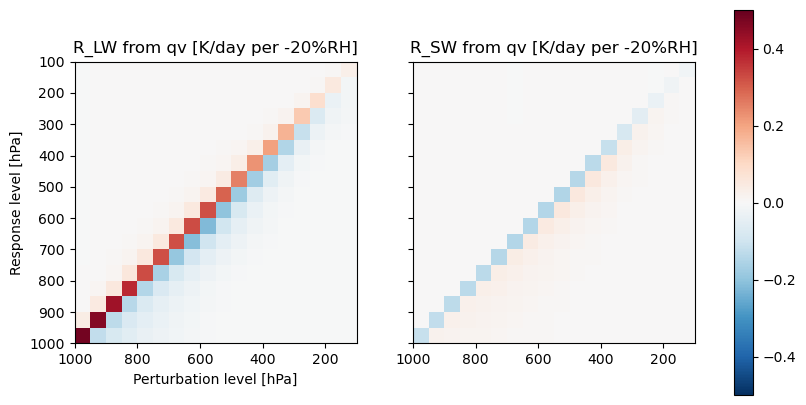

In [37]:
rad_base = climlab.radiation.RRTMG(name='Rad_base',
                                   state=state,
                                   specific_humidity=qvs_lev,
                                   albedo=0.3)

rad_base.compute_diagnostics()
LW_ref = rad_base.diagnostics['TdotLW'].copy()
SW_ref = rad_base.diagnostics['TdotSW'].copy()

kernel_LW = np.zeros((nlev, nlev))
kernel_SW = np.zeros((nlev, nlev))

for k in range(nlev):
    # qv perturbation at k lev, RH80 to RH100
    qv_pert = qvs_lev.copy()
    delta_qv = qvs_lev * 0.2 # [kg/kg]
    qv_pert[k] -= delta_qv[k]

    # Fresh radiation model per perturbation
    rad_pert = climlab.radiation.RRTMG(name=f'Rad_pert_{k}',
                                       state=state,
                                       specific_humidity=qv_pert,
                                       albedo=0.3)
    rad_pert.compute_diagnostics()
    LW_pert = rad_pert.diagnostics['TdotLW'].copy()
    SW_pert = rad_pert.diagnostics['TdotSW'].copy()

    # Compute kernel column (response at all levels to impulse at level k)
    kernel_LW[:, k] = (LW_pert - LW_ref) #/ (delta_qv * 1000)
    kernel_SW[:, k] = (SW_pert - SW_ref) #/ (delta_qv * 1000)
    
# === Step 7: Plot total radiative response kernel ===
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
cs1 = axs[0].pcolormesh(aavep, aavep, (kernel_LW), cmap='RdBu_r',
                        vmin=-0.5, vmax=0.5)
cs2 = axs[1].pcolormesh(aavep, aavep, (kernel_SW), cmap='RdBu_r',
                        vmin=-0.5, vmax=0.5)
# cs1 = axs[0].pcolormesh(aavep, aavep, (kernel_LW), cmap='RdBu_r',
#                         vmin=-40, vmax=40)
# cs2 = axs[1].pcolormesh(aavep, aavep, (kernel_SW), cmap='RdBu_r',
#                         vmin=-40, vmax=40)
cbar = fig.colorbar(cs1, ax=axs)

for ax in axs:
    ax.set_aspect('equal')
del ax
#plt.contour(p_levels, p_levels, (kernel_LW + kernel_SW)*1e-3, levels=[0,0.001],color='k')
axs[0].set_xlim([1000, 100])
axs[0].set_ylim([1000, 100])
axs[0].set_xlabel('Perturbation level [hPa]')
axs[0].set_ylabel('Response level [hPa]')
axs[0].set_title('R_LW from qv [K/day per -20%RH]')
axs[1].set_title('R_SW from qv [K/day per -20%RH]')